<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/bert_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 523.0 kB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split


import os 

In [4]:
import warnings
warnings.filterwarnings(action  = 'ignore')

In [ ]:
%config Completer.use_jedi = False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train.shape

(7613, 5)

In [9]:
df_test.shape

(3263, 4)

In [10]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


##EDA

<Axes: xlabel='text', ylabel='Density'>

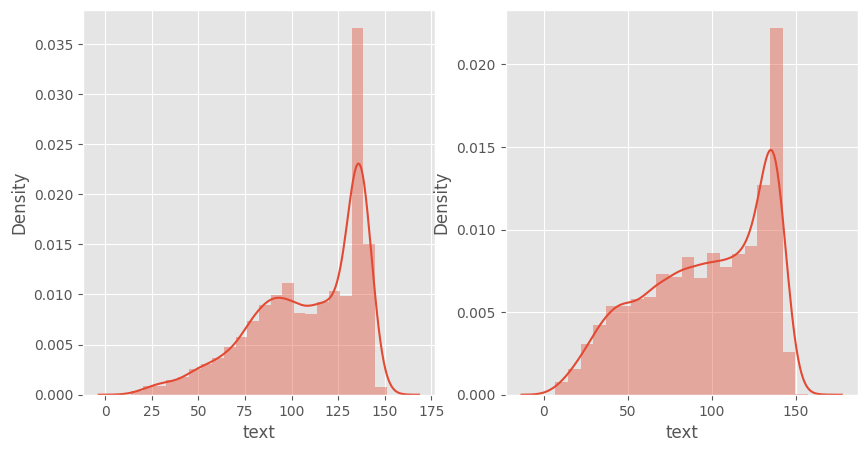

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
len_tweets = df_train[df_train['target']==1]['text'].str.len()
sns.distplot(len_tweets, ax = ax1)
n_len_tweets = df_train[df_train['target']==0]['text'].str.len()
sns.distplot(n_len_tweets, ax = ax2)

##데이터 정제

In [12]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=0080db6ef96fc005eb5e90f1f94ceff4d84b314971897992a26b448d04c771df
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Successfully built emoji


In [13]:
import emoji

def text_preproccessing(df):  
    
    df = df.copy()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text'] = df['text'].apply(lambda x : emoji.demojize(x))
    
    return df


In [14]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

In [15]:
df_train.shape

(7613, 5)

In [16]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [17]:
df_test.shape

(3263, 4)

In [18]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
max_length = max([len(sent.split()) for sent in df_train.text ])
print(max_length)

31


In [20]:
max_length = max([len(sent.split()) for sent in df_test.text ])
print(max_length)

31


In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00


In [22]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)

In [35]:
train_data = tokenizer(
text = train_data.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [36]:
train_data

{'input_ids': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  5796,  4328, ...,     0,     0,     0],
       [  101,  8026, 14887, ...,     0,     0,     0],
       [  101,  3963,  2086, ...,     0,     0,     0],
       ...,
       [  101,  5043,  2007, ...,     0,     0,     0],
       [  101,  2663,  5622, ...,     0,     0,     0],
       [  101,  5506,  2314, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [37]:
val_data = tokenizer(
text = val_data.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

##Model

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [39]:
max_len = 34


input_ids = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 34)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 34,                                            

In [42]:
train_data['input_ids']

<tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  5796,  4328, ...,     0,     0,     0],
       [  101,  8026, 14887, ...,     0,     0,     0],
       [  101,  3963,  2086, ...,     0,     0,     0],
       ...,
       [  101,  5043,  2007, ...,     0,     0,     0],
       [  101,  2663,  5622, ...,     0,     0,     0],
       [  101,  5506,  2314, ...,     0,     0,     0]], dtype=int32)>

In [46]:
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')


model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=2                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

In [47]:
train_history = model.fit(
    x ={'input_ids':train_data['input_ids'],'input_mask':train_data['attention_mask']} ,
    y = train_labels,
    validation_data = ({'input_ids':val_data['input_ids'],'input_mask':val_data['attention_mask']},val_labels),
    callbacks=callbacks_list,
    #validation_split = 0.1,
    epochs=20,
    batch_size=10
)

Epoch 1/20
609/609 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8099
Epoch 1: val_accuracy improved from -inf to 0.82403, saving model to checkpoint_path.keras
609/609 [==============================] - 99s 137ms/step - loss: 0.4541 - accuracy: 0.8099 - val_loss: 0.4133 - val_accuracy: 0.8240
Epoch 2/20
609/609 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8365
Epoch 2: val_accuracy improved from 0.82403 to 0.83322, saving model to checkpoint_path.keras
609/609 [==============================] - 81s 133ms/step - loss: 0.4015 - accuracy: 0.8365 - val_loss: 0.4056 - val_accuracy: 0.8332
Epoch 3/20
609/609 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8476
Epoch 3: val_accuracy did not improve from 0.83322
609/609 [==============================] - 72s 119ms/step - loss: 0.3840 - accuracy: 0.8476 - val_loss: 0.4061 - val_accuracy: 0.8313
Epoch 4/20
609/609 [==============================] - ETA: 0s - loss: 0.38

In [48]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras', custom_objects={"TFBertModel": TFBertModel})

In [49]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=34,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [50]:
x_test['attention_mask']

<tf.Tensor: shape=(3263, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [51]:
predicted = loaded_model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

102/102 [==============================] - 12s 79ms/step


In [52]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)